In [1]:
# Maybe you will need to install mamba_ssm like this:
# pip install mamba_ssm==2.1.0 --no-build-isolation

In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import List, Optional

import torch
from mamba_ssm import Mamba

import collections

from prettytable import PrettyTable


/home/rawthil/Documents/Medidas I - Catedra/Python Scope/pulsos-telefonicos/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE_USE = "cuda" # "cuda"

# Definitions

In [4]:
# Donde esta la data de los tonos del telefono
FILES = "../data/tektronic-2024" 

# Vamos a procesar solo una señal de tension, asi que vamos a tener solo un canal
SIGNAL_CHANNELS = 1

# Fraccion de muestras que vamos a usar para validar el entrenamiento (no se usan para entrenar)
valid_split = 0.10
# Cantidad de nuestras ve la red neuronal a cada vez durante el entrenamiento
sample_len = 64

# Mamba Hyperparameters:

# Cantidad de capas de bloques recursivos
n_layers = 3
# Dimension del espacio latente
latent_state_dim = 32 
# Dimension de expansion dentro del bloque recursivo
expand = 5 
# Tamaño del kernel interno del bloque
kernel_size = 4



# Hiperparametros de entrenamiento:

# Cantidad de veces voy a pasar TODA la data de entrenamiento por la red
epochs = 500
# Velocidad con la que actualizo los pesos de la red
lr = 1e-3
# Cantidad de muestras que tomo al mismo tiempo y uso para suavizar el calculo del gradiente
batch_size = 64
# Aca vamos a escribir los archivos de log
TENSORBOARD_FILE = "../outputs/mamba-classifier"
# Aca se va a guardar
SAVE_PATH = "../outputs/mamba-classifier-model"

# Dataset Generation

### Leemos la data

In [5]:

tones_dict = dict()
for folder in os.listdir(FILES):
    subfolder = os.path.join(FILES,folder)

    if 'TIEMPO' in subfolder:
        
        for file in os.listdir(subfolder):

            if '.CSV' in file:
                data=np.genfromtxt(os.path.join(subfolder,file),delimiter=',')

                name = subfolder.split("Medicion Tono ")[-1].split(" - TIEMPO")[0]
                tones_dict[name] = data[:,4] # Tono

                tiempo  =data[:,3]
                
sample_rate = (tiempo[1]-tiempo[0])
f_muestreo = 1/sample_rate



In [6]:
# sort the dictionary
tones_dict = collections.OrderedDict(sorted(tones_dict.items()))

In [7]:
print("la red va a ver %0.2f ms de señal"%(sample_len*sample_rate*1e3))

la red va a ver 2.56 ms de señal


In [8]:
# Calculo el maximo y minimo de las señales
max_min = [0,0]
for clase, key in enumerate(tones_dict.keys()):
    if max(tones_dict[key]) > max_min[0]:
        max_min[0] = max(tones_dict[key])
    if min(tones_dict[key]) > max_min[1]:
        max_min[1] = min(tones_dict[key])

In [9]:
# Las clases a clasificar son la cantidad de teclas que grabamos
NUM_CLASES = len(list(tones_dict.keys()))


valid_split = 0.10
sample_len = 64
train_samples_list = list()
train_targets_list = list()
validation_samples_list = list()
validation_targets_list = list()
for clase, key in enumerate(tones_dict.keys()):

    # Normalizamos
    signa_use = tones_dict[key]
    signa_use = (signa_use-max_min[1])/(max_min[0]-max_min[1])

    total_len = len(signa_use)

    total_len_valid = np.round(total_len*valid_split).astype(int)

    for sample_t in range(0,total_len-total_len_valid):

        if (sample_t + sample_len ) >= total_len:
            break

        # crop sample
        this_sample = np.expand_dims(signa_use[sample_t:sample_t+sample_len], axis =-1)
                
        # one-hot target
        this_target = np.zeros((NUM_CLASES))
        this_target[clase] = 1

        train_samples_list.append(this_sample)
        train_targets_list.append(this_target)
    
    for sample_t in range(total_len-total_len_valid,total_len):
        
        if (sample_t + sample_len ) >= total_len:
            break

        # crop sample
        this_sample = np.expand_dims(signa_use[sample_t:sample_t+sample_len], axis =-1)
                
        # one-hot target
        this_target = np.zeros((NUM_CLASES))
        this_target[clase] = 1



        validation_samples_list.append(this_sample)
        validation_targets_list.append(this_target)
            
train_samples = np.array(train_samples_list)
print(train_samples.shape)
train_targets = np.array(train_targets_list)
print(train_targets.shape)
validation_samples = np.array(validation_samples_list)
print(validation_samples.shape)
validation_targets = np.array(validation_targets_list)
print(validation_targets.shape)

tensor_x = torch.Tensor(train_samples) # transform to torch tensor
tensor_y = torch.Tensor(train_targets)
train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
tensor_x = torch.Tensor(validation_samples) # transform to torch tensor
tensor_y = torch.Tensor(validation_targets)
validation_dataset = TensorDataset(tensor_x,tensor_y) # create your datset




(27000, 64, 1)
(27000, 12)
(2232, 64, 1)
(2232, 12)


# Neural Network Creation

Aca creamos la red neuronal, va a ser una red recurrente tipo MAMBA, es importante destacar que el tamaño (largo) de la señal no es parte del modelo, es decir, predice de manera continua.

In [10]:

class RMSNorm(torch.nn.Module):
    def __init__(self, size: int, epsilon: float = 1e-5, bias: bool = False):
        super().__init__()

        self.epsilon = epsilon
        self.weight = torch.nn.Parameter(torch.ones(size))
        self.bias = torch.nn.Parameter(torch.zeros(size)) if bias else None

    def forward(self, x):
        normed_x = (
            x
            * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.epsilon)
            * self.weight
        )

        if self.bias is not None:
            return normed_x + self.bias

        return normed_x


class MambaSignal(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        n_layers: int = 1,
        latent_state_dim: int = 16,
        expand: int = 2,
        kernel_size: int = 4,
        dropout: float = 0,
    ):
        super().__init__()

        
        self.head1 = torch.nn.Sequential(
            *[
                Mamba(
                    d_model=in_channels,
                    d_state=latent_state_dim,
                    expand=expand,
                    d_conv=kernel_size,
                )
                for _ in range(n_layers)
            ]
        )
        self.head2 = torch.nn.Sequential(
            *[
                Mamba(
                    d_model=in_channels,
                    d_state=latent_state_dim,
                    expand=expand,
                    d_conv=kernel_size,
                )
                for _ in range(n_layers)
            ]
        )
        self.head3 = torch.nn.Sequential(
            *[
                Mamba(
                    d_model=in_channels,
                    d_state=latent_state_dim,
                    expand=expand,
                    d_conv=kernel_size,
                )
                for _ in range(n_layers)
            ]
        )
        self.head4 = torch.nn.Sequential(
            *[
                Mamba(
                    d_model=in_channels,
                    d_state=latent_state_dim,
                    expand=expand,
                    d_conv=kernel_size,
                )
                for _ in range(n_layers)
            ]
        )

        self.norm = RMSNorm(in_channels)
        self.dropout = torch.nn.Dropout(dropout)

        self.linear = torch.nn.Linear(in_channels*4, out_channels)

        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # Get last batch of labels
        x1 = self.head1(x)[:,-1]
        x2 = self.head2(x)[:,-1]
        x3 = self.head3(x)[:,-1]
        x4 = self.head4(x)[:,-1]

        x = torch.concat((x1,x2,x3,x3), dim=-1)

        x = self.linear(x)

        return self.softmax(x)


In [11]:
# define model
model: torch.nn.Module = (
    MambaSignal(
        in_channels=SIGNAL_CHANNELS,
        n_layers=n_layers,
        latent_state_dim=latent_state_dim,
        expand = expand,
        kernel_size = kernel_size,
        out_channels=NUM_CLASES,
    )
    .to(DEVICE_USE)
)

In [12]:
# Testeamos
x = torch.randn(8, sample_len, 1).to(DEVICE_USE)
y = model(x)
print(x.shape, y.shape)

torch.Size([8, 64, 1]) torch.Size([8, 12])


In [13]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|      head1.0.A_log      |    160     |
|        head1.0.D        |     5      |
|  head1.0.in_proj.weight |     10     |
|  head1.0.conv1d.weight  |     20     |
|   head1.0.conv1d.bias   |     5      |
|  head1.0.x_proj.weight  |    325     |
|  head1.0.dt_proj.weight |     5      |
|   head1.0.dt_proj.bias  |     5      |
| head1.0.out_proj.weight |     5      |
|      head1.1.A_log      |    160     |
|        head1.1.D        |     5      |
|  head1.1.in_proj.weight |     10     |
|  head1.1.conv1d.weight  |     20     |
|   head1.1.conv1d.bias   |     5      |
|  head1.1.x_proj.weight  |    325     |
|  head1.1.dt_proj.weight |     5      |
|   head1.1.dt_proj.bias  |     5      |
| head1.1.out_proj.weight |     5      |
|      head1.2.A_log      |    160     |
|        head1.2.D        |     5      |
|  head1.2.in_proj.weight |     10     |
|  head1.2.conv1

6541

# Training

In [14]:
# define loss and optimizer
loss: torch.nn.Module = torch.nn.MSELoss()
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [15]:
train_dataloader = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                    shuffle=True,)


validation_dataloader = DataLoader(validation_dataset,
                                   batch_size=batch_size,
                                    shuffle=True,)


In [16]:

class Accuracy:
    """
    This class is the accuracy object.

    Attributes:
        correct: number of correct predictions.
        total: number of total examples to classify.
    """

    correct: int
    total: int

    def __init__(self) -> None:
        """
        This is the constructor of Accuracy class. It should
        initialize correct and total to zero.
        """

        self.correct = 0
        self.total = 0

    def update(self, logits: torch.Tensor, labels: torch.Tensor) -> None:
        """
        This method update the value of correct and total counts.

        Args:
            logits: outputs of the model.
                Dimensions: [batch, number of classes]
            labels: labels of the examples. Dimensions: [batch].
        """

        oh = torch.nn.functional.one_hot(logits.argmax(dim=-1), num_classes=labels.shape[-1])
        
        self.correct += int((oh*labels).sum())
        self.total += labels.shape[0]


        return None

    def compute(self) -> float:
        """
        This method returns the accuracy value.

        Returns:
            accuracy value.
        """

        return self.correct / self.total

    def reset(self) -> None:
        """
        This method resets to zero the count of correct and total number of
        examples.
        """

        # init to zero the counts
        self.correct = 0
        self.total = 0

        return None

In [17]:
from typing import Optional

@torch.enable_grad()
def train_step(
    model: torch.nn.Module,
    train_data: DataLoader,
    loss: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    writer: SummaryWriter,
    epoch: int,
    device: torch.device,
    accuracy: Accuracy = Accuracy(),
) -> None:
    """
    This function train the model.

    Args:
        model: model to train.
        train_data: dataloader of train data.
        loss: loss function.
        optimizer: optimizer.
        writer: writer for tensorboard.
        epoch: epoch of the training.
        device: device for running operations.
    """
    # Training
    model.train()
    losses = []

    for inputs, targets in train_data:
        inputs, targets = inputs.to(device), targets.to(device)

        # forward
        outputs = model(inputs)

        # Compute loss
        loss_value = loss(outputs, targets)
        losses.append(loss_value.item())

        optimizer.zero_grad()
        loss_value.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), .50)
        optimizer.step()

        accuracy.update(outputs, targets)


    # Write to tensorboard
    writer.add_scalar("train/loss", np.mean(losses), epoch)

    writer.add_scalar("train/accuracy", accuracy.compute(), epoch)
    accuracy.reset()



@torch.no_grad()
def val_step(
    model: torch.nn.Module,
    val_data: DataLoader,
    loss: torch.nn.Module,
    scheduler: Optional[torch.optim.lr_scheduler.LRScheduler],
    writer: SummaryWriter,
    epoch: int,
    device: torch.device,
    accuracy: Accuracy = Accuracy(),
) -> None:
    """
    This function train the model.

    Args:
        model: model to train.
        val_data: dataloader of validation data.
        loss: loss function.
        scheduler: scheduler.
        writer: writer for tensorboard.
        epoch: epoch of the training.
        device: device for running operations.
    """
    # Validation
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, targets in val_data:
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            outputs = model(inputs)

            # Compute loss
            loss_value = loss(outputs, targets)
            losses.append(loss_value.item())

            # Update accuracy
            accuracy.update(outputs, targets)


    if scheduler is not None:
        scheduler.step()

    # Write to tensorboard
    writer.add_scalar("val/loss", np.mean(losses), epoch)

    writer.add_scalar("val/accuracy", accuracy.compute(), epoch)
    accuracy.reset()


In [18]:
writer = SummaryWriter(TENSORBOARD_FILE)

accuracy = Accuracy()
# define an empty scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)
# Train the model
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
    # call train step
    train_step(
        model, train_dataloader, loss, optimizer, writer, epoch, DEVICE_USE, accuracy
    )

    # call val step
    val_step(model, validation_dataloader, loss, scheduler, writer, epoch, DEVICE_USE, accuracy)

    # clear the GPU cache
    torch.cuda.empty_cache()

100%|██████████| 500/500 [18:32<00:00,  2.22s/it]


In [19]:
torch.save(model.state_dict(), SAVE_PATH)

# Reload Model, just because

In [20]:
MODEL_CHKP = SAVE_PATH #+ "-OK"
model.load_state_dict(torch.load(MODEL_CHKP, map_location=torch.device(DEVICE_USE)))

<All keys matched successfully>

# Validation Results

Aca miramos un poco que tan bien quedo el modelo

In [21]:
signal_pred = np.zeros((len(validation_dataset)))
signal_target = np.zeros((len(validation_dataset)))
data_conf_mat = np.zeros((NUM_CLASES,NUM_CLASES))

i = 0
for sample, target in validation_dataset:

    y_hat = model(sample[None, :, : ].to(DEVICE_USE))

    class_pred = np.argmax(target.to("cpu").numpy(), axis=-1), 
    class_target = np.argmax(y_hat.to("cpu").detach().numpy(), axis=-1)

    data_conf_mat[class_target, class_pred] += 1

    signal_pred[i] = class_pred[0]
    signal_target[i] = class_target[0]

    i+=1
    



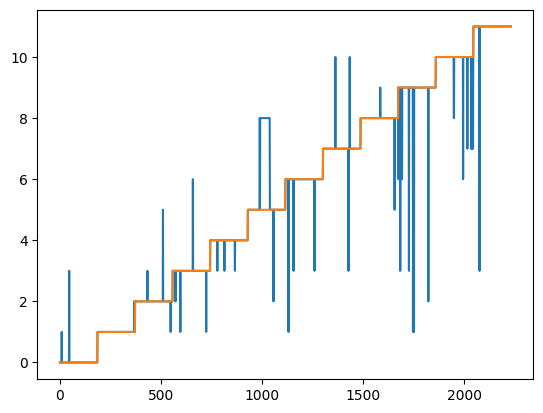

In [22]:
plt.plot(signal_target)
plt.plot(signal_pred)
plt.show()

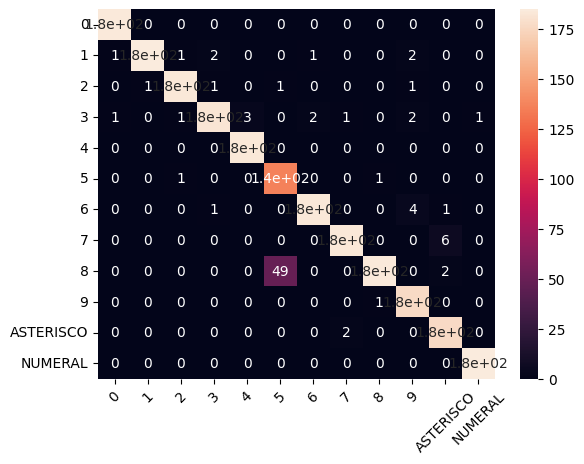

In [24]:
# Ploteamos la matriz de confusion que nos dice visualmente donde y como se equivoca la red al clasificar
# Una matriz diaganonal es un clasificador perfecto

df_cm = pd.DataFrame(data_conf_mat, index = [str(i) for i in tones_dict.keys()],
                  columns = [str(i) for i in tones_dict.keys()])
plt.figure(dpi = 100)
sn.heatmap(df_cm, annot=True)
ax = plt.gca()
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='y', labelrotation=0)
plt.show()